In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
import math

# Esercizio 1. Predizione della qualità di un vino partendo da risultati di test fisico-chimici mediante percettrone multi-strato
Con riferimento all'esercizio tutorial descritto in 'neural_networks_regression.ipynb', risolvere il problema affrontato con regressione mediante classificazione. 

Per fare ciò occorre modificare:

*   encoding delle etichette (one-hot encoding, vedi sotto), sia in fase di training sia di testing 
*   lo strato di uscita con un neurone per classe (11 in tot), attivati mediante softmax (activation='softmax')
*   funzione costo (tf.keras.losses.CategoricalCrossentropy())
*   metriche di performance (tf.keras.metrics.CategoricalAccuracy())
*   (class weighting per dataset sbilanciati)





(1599, 11)
(1599,)


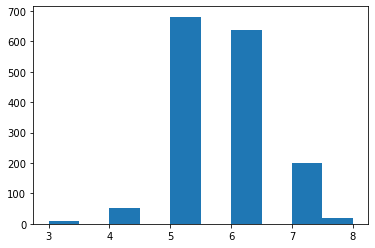

Number of input features: 11
Number of total examples: 1599
Training set number of examples: 1279
Test set number of examples: 320


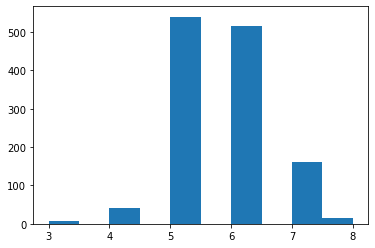

6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 11)]              0         
 )                                                               
                                                                 
 dense_layer0 (Dense)        (None, 64)                768       
                                                                 
 dense_layer1 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer_output (Dense)  (None, 11)                715       
                                                                 
Total params: 5643 (22.04 KB)
Trainable params: 5643 (22.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Prepare the dataset.
data = np.load('winequality-red.npz') # /path/to/winequality-red.npz
x = data['x']
y = data['y']
print(x.shape)
print(y.shape)
plt.hist(y)
plt.show()
ntot_examples = x.shape[0]
nfeatures = x.shape[-1]
nexamples = math.floor(0.8*ntot_examples)

print('Number of input features: {0}'.format(nfeatures))
print('Number of total examples: {0}'.format(ntot_examples))
print('Training set number of examples: {0}'.format(nexamples))
print('Test set number of examples: {0}'.format(ntot_examples-nexamples))

x_train = x[:nexamples,:]
y_train = y[:nexamples]
x_test = x[nexamples:, :]
y_test = y[nexamples:]

# MODIFICA NO. 1 RISPETTO A REGRESSIONE
# 'one-hot encoding'
plt.hist(y_train)
plt.show()

y_train_onehot = np.zeros((y_train.shape[0], 11))
y_train_onehot[np.arange(y_train.shape[0]), y_train] = 1

y_test_onehot = np.zeros((y_test.shape[0], 11))
y_test_onehot[np.arange(y_test.shape[0]), y_test] = 1
print(y_test[0])
print(y_test_onehot[0,:])
####

mean_train = x_train.mean(axis=0)
std_train = x_train.std(axis=0)
x_train -= mean_train
x_train /= std_train
x_test -= mean_train
x_test /= std_train

# MODIFICA NO. 2 RISPETTO A REGRESSIONE
# attivazione neuroni di uscita e loss function

# Model design. 
inputs = keras.Input(shape=(nfeatures,), name="input_features")
x1 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer0')(inputs)
x2 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer1')(x1)
outputs = layers.Dense(11, activation='softmax', name="dense_layer_output")(x2)
model = keras.Model(inputs=inputs, outputs=outputs, name='MLP')
model.summary()
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [10]:
nepochs = 50#250
bs = 64
nexamples = x_train.shape[0]

idx_start = np.arange(0, x_train.shape[0], bs)
idx_stop = np.roll(idx_start, shift=-1)
idx_stop[-1] = x_train.shape[0]

nbatches = idx_start.shape[0]
print('Number of batches ({0} examples, {1} mini-batch size): {2}, first: {3}, last: {4}'.format(nexamples, bs, nbatches, 
                                                             [idx_start[0], idx_stop[0]],
                                                             [idx_start[-1], idx_stop[-1]]))
seed = 1234
np.random.seed(seed)

# Iterate over epochs.
train_losses = []
train_losses_it = []
for epoch in np.arange(nepochs): # epoca 0: epoca 49
    # Shuffling training data at the start of each epoch
    idx = np.arange(x_train.shape[0]) # idx: [0,1,2,...,1278] valori da 0 a 1279
    np.random.shuffle(idx)# idx: [100, 2, 5, 1, 137, 7,...] valori da 0 a 1279
    loss = []
    # Iterate over the batches of the dataset.
    for step in np.arange(nbatches): # step 0: step 19
        # Extracting mini-batch.
        # idx_start[step=0] = 0, idx_stop[step=0] = 64
        # idx[idx_start[0]: idx_stop[0]]
        idx_batch = idx[idx_start[step]: idx_stop[step]] # 
        x_batch_train = x_train[idx_batch, :]
        y_batch_train = y_train_onehot[idx_batch, :]
        # Converting numpy arrays to tensorflow tensors.
        x_batch_train = tf.convert_to_tensor(x_batch_train)
        y_batch_train = tf.convert_to_tensor(y_batch_train)
        # Open a GradientTape to record the operations run during the forward-pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward-pass of the layer.
            preds = model(x_batch_train, training=True)
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, preds)
        # Use the gradient tape to automatically retrieve the gradients of loss with respect to the trainable parameters.
        grads = tape.gradient(loss_value, model.trainable_weights)
        # Run one step of gradient descent by updating the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # grads: grad(L/w0), grad(L/w1),..., 
        # model.trainable_weights: w0, w1,..., 
        
        loss.append(loss_value) # lista di 20
    train_losses_it.extend(loss)
    train_loss = np.mean(loss)  # Averaging mini-batch losses
    print('Epoch {0}, train loss: {1}'.format(epoch, train_loss))
    train_losses.append(train_loss)

Number of batches (1279 examples, 64 mini-batch size): 20, first: [0, 64], last: [1216, 1279]
Epoch 0, train loss: 0.6960540413856506
Epoch 1, train loss: 0.691912055015564
Epoch 2, train loss: 0.6864355802536011
Epoch 3, train loss: 0.6829811334609985
Epoch 4, train loss: 0.6808038949966431
Epoch 5, train loss: 0.6798418760299683
Epoch 6, train loss: 0.6763420104980469
Epoch 7, train loss: 0.6704526543617249
Epoch 8, train loss: 0.6672490239143372
Epoch 9, train loss: 0.6638211011886597
Epoch 10, train loss: 0.6581031680107117
Epoch 11, train loss: 0.653873085975647
Epoch 12, train loss: 0.6535899043083191
Epoch 13, train loss: 0.646511971950531
Epoch 14, train loss: 0.6408082246780396
Epoch 15, train loss: 0.6399871706962585
Epoch 16, train loss: 0.6369974613189697
Epoch 17, train loss: 0.6312626004219055
Epoch 18, train loss: 0.6299301981925964
Epoch 19, train loss: 0.6286767721176147
Epoch 20, train loss: 0.6216782927513123
Epoch 21, train loss: 0.6186612844467163
Epoch 22, train l

Text(0, 0.5, 'MSE (log)')

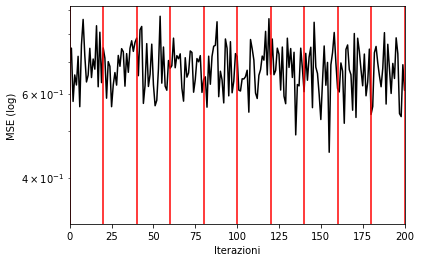

In [11]:
plt.semilogy(np.arange(nepochs*nbatches), train_losses_it, 'k')
for i in np.arange(0, nepochs*nbatches, nbatches):
    plt.axvline(i, c='r')
plt.xlim([0, 10*nbatches])
plt.xlabel('Iterazioni')
plt.ylabel('MSE (log)')
# potete plottare anche la funzione costo su singoli step (singoli mini-batch)
# valutare la variabilità (np.std) della funzione costo tra le valutazioni di mini-batch in 1 epoca
# variando il mini-batch size 

In [12]:
# Network evaluation at each epoch on both training and test set (alla fine ultima!!)
acc_fn = tf.keras.metrics.CategoricalAccuracy()

preds = model(x_train, training=False)
train_acc = acc_fn(preds, tf.convert_to_tensor(y_train_onehot))

preds = model(x_test, training=False)
test_acc = acc_fn(preds, tf.convert_to_tensor(y_test_onehot))
print('Train acc: {0}'.format(train_acc))
print('Test acc: {0}'.format(test_acc))


Train acc: 0.8131352663040161
Test acc: 0.7686053514480591


(1599, 11)
(1599,)


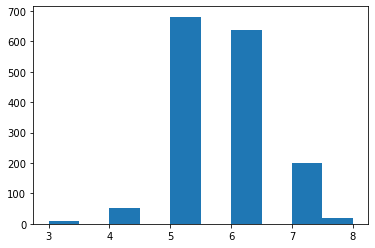

Number of input features: 11
Number of total examples: 1599
Training set number of examples: 1279
Test set number of examples: 320


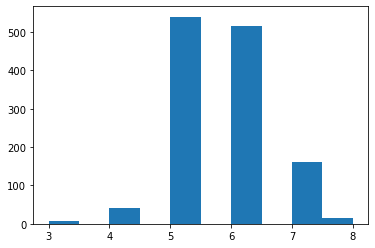

[0, 0, 0, 7, 42, 540, 515, 160, 15, 0, 0]
{0: 1.0, 1: 1.0, 2: 1.0, 3: 77.14285714285714, 4: 12.857142857142858, 5: 1.0, 6: 1.0485436893203883, 7: 3.375, 8: 36.0, 9: 1.0, 10: 1.0}
6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 11)]              0         
 )                                                               
                                                                 
 dense_layer0 (Dense)        (None, 64)                768       
                                                                 
 dense_layer1 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer_output (Dense)  (None, 11)                715       
                                                                 
Total params: 5643 (22.04 KB)
Trainable param

In [13]:
# Prepare the dataset.
data = np.load('winequality-red.npz') # /path/to/winequality-red.npz
x = data['x']
y = data['y']
print(x.shape)
print(y.shape)
plt.hist(y)
plt.show()
ntot_examples = x.shape[0]
nfeatures = x.shape[-1]
nexamples = math.floor(0.8*ntot_examples)

print('Number of input features: {0}'.format(nfeatures))
print('Number of total examples: {0}'.format(ntot_examples))
print('Training set number of examples: {0}'.format(nexamples))
print('Test set number of examples: {0}'.format(ntot_examples-nexamples))


x_train = x[:nexamples,:]
y_train = y[:nexamples]
x_test = x[nexamples:, :]
y_test = y[nexamples:]

# INCLUSIONE ANCHE DI CLASS-WEIGHTING
# 'pesare' le classi per unbalanced data
plt.hist(y_train)
plt.show()
nexamples_lst = [(y_train==i).sum() for i in np.arange(11)]
nmax_examples = np.max(nexamples_lst)
class_weights={}
for i in np.arange(11):
    if nexamples_lst[i]!=0:
        class_weights[i] = nmax_examples/nexamples_lst[i]
    else:
        class_weights[i] = 1.
print(nexamples_lst)
print(class_weights)

y_train_onehot = np.zeros((y_train.shape[0], 11))
y_train_onehot[np.arange(y_train.shape[0]), y_train] = 1

y_test_onehot = np.zeros((y_test.shape[0], 11))
y_test_onehot[np.arange(y_test.shape[0]), y_test] = 1
print(y_test[0])
print(y_test_onehot[0,:])
####

mean_train = x_train.mean(axis=0)
std_train = x_train.std(axis=0)
x_train -= mean_train
x_train /= std_train
x_test -= mean_train
x_test /= std_train

# Model design. 
inputs = keras.Input(shape=(nfeatures,), name="input_features")
x1 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer0')(inputs)
x2 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer1')(x1)
outputs = layers.Dense(11, activation='softmax', name="dense_layer_output")(x2)
model = keras.Model(inputs=inputs, outputs=outputs, name='MLP')
model.summary()
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy()
# Instantiate a metric function.
acc_fn = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[acc_fn,])
model.fit(x=x_train,y=y_train_onehot,batch_size=bs,
          epochs=250,
          shuffle=True,
          class_weight=class_weights
)

In [14]:
# Network evaluation at each epoch on both training and test set (alla fine ultima!!)
acc_fn = tf.keras.metrics.CategoricalAccuracy()

preds = model(x_train, training=False)
train_acc = acc_fn(preds, tf.convert_to_tensor(y_train_onehot))

preds = model(x_test, training=False)
test_acc = acc_fn(preds, tf.convert_to_tensor(y_test_onehot))
print('Train acc: {0}'.format(train_acc))
print('Test acc: {0}'.format(test_acc))

Train acc: 0.8506645560264587
Test acc: 0.7904940843582153


# Esercizio 2. Classificazione di caratteri scritti a mano su carta (handwritten digit classification) mediante rete neurale convoluzionale

Il compito di classificazione obiettivo consiste nell'associare l'etichetta corretta a numeri scritti a mano riportati in un'immagine gray-scale di dimensioni 28x28. Quindi, essendoci 10 possibili digit (0,...,9) il compito consiste nella discriminazione di 10 possibili classi.

Il dataset è disponibile pubblicamente online (http://yann.lecun.com/exdb/mnist/) ma utilizzeremo le funzioni di keras per caricarlo in memoria (vedi sotto). 

Utilizzare una rete neurale convoluzionale (CNN) per risolvere il problema di classificazione. Definire la seguente sequenza di strati:


INPUT-CONV-MAXPOOL-DROPOUT-CONV-MAXPOOL-DROPOUT-FLATTEN-DENSE(OUTPUT)


Definire gli strati intermedi con: 
 
*   Conv2D(16, kernel_size=(5, 5), in cui viene eseguita la convoluzione con 16 filtri convoluzionali addestrabili 5x5
*   MaxPooling2D(pool_size=(2, 2), in cui viene eseguito l'operatore di max pooling per dimezzare le dimensioni spaziali (ridurre computazioni)
*   Dropout(0.25), operatore di dropout (dropout rate=0.25)
*   Flatten()

Vedete anche i seguenti link per comprendere meglio il funzionamento di CNN per classificazione di digits:
https://adamharley.com/nn_vis/cnn/2d.html.

Addestrare e testare il modello. 

N.B. visto che ci sono molti esempi, valutare di addestrare per poche epoche (es. fino 50) con mini-batch size elevati (es. 128 o 256).

11490434/11490434 [==============================] - 2s 0us/step
Input data type: uint8
Min value: 0
Max value: 255
Shape of the training examples: (60000, 28, 28)
Shape of the test examples: (10000, 28, 28)


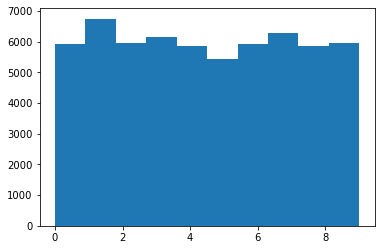

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 activation (Activation)     (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          12832     
                                                                 
 activation_1 (Activation)   (None, 8, 8, 32)          0         
                      

In [15]:
# Prepare the dataset.
# load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() # uint8 (0-255)
N = 28 # number of rows and columns of the input square matrix
C = 10 # number of total classes (e.g., 10 possible digits)

print("Input data type:", x_train.dtype)
print("Min value:", x_train.min())
print("Max value:", x_train.max())
print("Shape of the training examples:", x_train.shape)
print("Shape of the test examples:", x_test.shape)

plt.hist(y_train)
plt.show()

y_train_onehot = np.zeros((y_train.shape[0], 10))
y_train_onehot[np.arange(y_train.shape[0]), y_train] = 1

y_test_onehot = np.zeros((y_test.shape[0], 10))
y_test_onehot[np.arange(y_test.shape[0]), y_test] = 1
print(y_test[0])
print(y_test_onehot[0,:])

mean_train = x_train.mean(axis=0)
std_train = x_train.std(axis=0)
x_train = x_train-mean_train
x_train = x_train/(std_train+1e-16)
x_test = x_test-mean_train
x_test = x_test/(std_train+1e-16)

# Model design. 
input_shape = (N, N, 1) # input dimension (grey-scale image 28 x 28, represented as a single input feature map 28x28x1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        keras.layers.Conv2D(16, kernel_size=(5, 5)),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),

        keras.layers.Conv2D(32, kernel_size=(5, 5)),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),

        keras.layers.Flatten(),
        
        keras.layers.Dense(C, activation="softmax"),
    ]
)

model.summary()
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [16]:
nepochs = 50#250
bs = 256
nexamples = x_train.shape[0]

idx_start = np.arange(0, x_train.shape[0], bs)
idx_stop = np.roll(idx_start, shift=-1)
idx_stop[-1] = x_train.shape[0]

nbatches = idx_start.shape[0]
print('Number of batches ({0} examples, {1} mini-batch size): {2}, first: {3}, last: {4}'.format(nexamples, bs, nbatches, 
                                                             [idx_start[0], idx_stop[0]],
                                                             [idx_start[-1], idx_stop[-1]]))
seed = 1234
np.random.seed(seed)

# Iterate over epochs.
train_losses = []
train_losses_it = []
for epoch in np.arange(nepochs): # epoca 0: epoca 49
    # Shuffling training data at the start of each epoch
    idx = np.arange(x_train.shape[0]) # idx: [0,1,2,...,1278] valori da 0 a 1279
    np.random.shuffle(idx)# idx: [100, 2, 5, 1, 137, 7,...] valori da 0 a 1279
    loss = []
    # Iterate over the batches of the dataset.
    for step in np.arange(nbatches): # step 0: step 19
        # Extracting mini-batch.
        # idx_start[step=0] = 0, idx_stop[step=0] = 64
        # idx[idx_start[0]: idx_stop[0]]
        idx_batch = idx[idx_start[step]: idx_stop[step]] # 
        x_batch_train = x_train[idx_batch, :]
        y_batch_train = y_train_onehot[idx_batch, :]
        # Converting numpy arrays to tensorflow tensors.
        x_batch_train = tf.convert_to_tensor(x_batch_train)
        y_batch_train = tf.convert_to_tensor(y_batch_train)
        # Open a GradientTape to record the operations run during the forward-pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward-pass of the layer.
            preds = model(x_batch_train, training=True)
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, preds)
        # Use the gradient tape to automatically retrieve the gradients of loss with respect to the trainable parameters.
        grads = tape.gradient(loss_value, model.trainable_weights)
        # Run one step of gradient descent by updating the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # grads: grad(L/w0), grad(L/w1),..., 
        # model.trainable_weights: w0, w1,..., 
        
        loss.append(loss_value) # lista di 20
    train_losses_it.extend(loss)
    train_loss = np.mean(loss)  # Averaging mini-batch losses
    print('Epoch {0}, train loss: {1}'.format(epoch, train_loss))
    train_losses.append(train_loss)

Number of batches (60000 examples, 256 mini-batch size): 235, first: [0, 256], last: [59904, 60000]
Epoch 0, train loss: 0.4531457722187042
Epoch 1, train loss: 0.13487757742404938
Epoch 2, train loss: 0.09531459212303162
Epoch 3, train loss: 0.07824321836233139
Epoch 4, train loss: 0.06972672790288925
Epoch 5, train loss: 0.060525082051754
Epoch 6, train loss: 0.05741031467914581
Epoch 7, train loss: 0.05188750475645065
Epoch 8, train loss: 0.04783247411251068
Epoch 9, train loss: 0.04671201482415199
Epoch 10, train loss: 0.044821847230196
Epoch 11, train loss: 0.041697848588228226
Epoch 12, train loss: 0.03994202986359596
Epoch 13, train loss: 0.039766643196344376
Epoch 14, train loss: 0.037970706820487976
Epoch 15, train loss: 0.036238089203834534
Epoch 16, train loss: 0.034137796610593796
Epoch 17, train loss: 0.032045282423496246
Epoch 18, train loss: 0.03290398791432381
Epoch 19, train loss: 0.03174817934632301
Epoch 20, train loss: 0.031417954713106155
Epoch 21, train loss: 0.02

In [17]:
# Network evaluation at each epoch on both training and test set (alla fine ultima!!)
acc_fn = tf.keras.metrics.CategoricalAccuracy()

preds = model(x_train, training=False)
train_acc = acc_fn(preds, tf.convert_to_tensor(y_train_onehot))

preds = model(x_test, training=False)
test_acc = acc_fn(preds, tf.convert_to_tensor(y_test_onehot))
print('Train acc: {0}'.format(train_acc))
print('Test acc: {0}'.format(test_acc))

Train acc: 0.9985833168029785
Test acc: 0.9977571368217468
